In [1]:
import pandas as pd
import os # Used for joining path components
import numpy as np # Useful for data manipulation later

# --- Configuration ---
# !! IMPORTANT: Set this to the actual path on your system !!
# This should be the path to the directory containing folders like 'Pt204_C_n_350', 'Pt...' etc.
# Example: 'D:/Courses/thesis/data/21h9f9e30v9cl2fapjggz4q1x7/Turning/Data/turning_2D3D_skeletons_coarsened/Turning_coarsen_CSV'
base_data_path = r'D:/Courses/thesis/data/21h9f9e30v9cl2fapjggz4q1x7/Turning/Data/turning_2D3D_skeletons_coarsened/Turning_coarsen_CSV' # <<<--- ADJUST THIS PATH

# Path to the labels file (adjust if it's not in the same directory as your notebook)
labels_file_path = r'D:/Courses/thesis/data/21h9f9e30v9cl2fapjggz4q1x7/Turning/Data/turning_human_labels/Turning_human_labels.csv'

print("Libraries imported and paths configured.")
print(f"Base data path set to: {base_data_path}")
print(f"Labels file path set to: {labels_file_path}")

Libraries imported and paths configured.
Base data path set to: D:/Courses/thesis/data/21h9f9e30v9cl2fapjggz4q1x7/Turning/Data/turning_2D3D_skeletons_coarsened/Turning_coarsen_CSV
Labels file path set to: D:/Courses/thesis/data/21h9f9e30v9cl2fapjggz4q1x7/Turning/Data/turning_human_labels/Turning_human_labels.csv


In [2]:
# --- Load Labels ---
try:
    df_labels = pd.read_csv(labels_file_path)
    print(f"Successfully loaded labels file: {labels_file_path}")
    print(f"Labels DataFrame shape: {df_labels.shape}")
    print("\nFirst 5 rows of labels:")
    display(df_labels.head()) # Use display() in notebooks for better formatting
    print("\nLabel columns and data types:")
    print(df_labels.info())

except FileNotFoundError:
    print(f"Error: Labels file not found at {labels_file_path}")
    df_labels = None # Set df_labels to None if file not found
except Exception as e:
    print(f"An error occurred loading the labels file: {e}")
    df_labels = None # Set df_labels to None on other errors

Successfully loaded labels file: D:/Courses/thesis/data/21h9f9e30v9cl2fapjggz4q1x7/Turning/Data/turning_human_labels/Turning_human_labels.csv
Labels DataFrame shape: (1749, 10)

First 5 rows of labels:


,Turn ID,Participant ID number,PD_or_C,number_of_turning_steps,turning_angle,type_of_turn,turning_duration,On_or_Off_medication,DBS_state,clinical_assessment
0,0,230,C,4,90_degrees,pivot_turn,1.980999,Control,Control,No
1,2,230,C,2,90_degrees,pivot_turn,1.278000,Control,Control,No
2,4,230,C,2,90_degrees,pivot_turn,1.092999,Control,Control,No
3,5,230,C,2,90_degrees,pivot_turn,1.205999,Control,Control,No
4,7,230,C,2,90_degrees,pivot_turn,1.399000,Control,Control,No



Label columns and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Turn ID                  1749 non-null   int64  
 1   Participant ID number    1749 non-null   int64  
 2   PD_or_C                  1749 non-null   object 
 3   number_of_turning_steps  1749 non-null   int64  
 4   turning_angle            1749 non-null   object 
 5   type_of_turn             1749 non-null   object 
 6   turning_duration         1749 non-null   float64
 7   On_or_Off_medication     1749 non-null   object 
 8   DBS_state                1749 non-null   object 
 9   clinical_assessment      1749 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 136.8+ KB
None


In [4]:
# --- Function to Load Keypoint Data ---
def load_turn_data(turn_info_row, dimension='2D', base_path='.'):
    """
    Loads the keypoint data for a specific turn episode.

    Args:
        turn_info_row (pd.Series): A row from the df_labels DataFrame.
        dimension (str): '2D' or '3D'.
        base_path (str): The base path to the 'Turning_coarsen_CSV' directory.

    Returns:
        pd.DataFrame or None: DataFrame with keypoint data or None if file not found/error.
    """
    try:
        # Extract necessary info from the label row
        # Making sure IDs are integers if they are read as floats from CSV initially
        participant_id = int(turn_info_row['Participant ID number'])
        pd_c_status = turn_info_row['PD_or_C']
        turn_id = int(turn_info_row['Turn ID']) # This corresponds to 'n' in the folder name

        # Construct the folder name based on convention from readme.txt
        folder_name = f"Pt{participant_id}_{pd_c_status}_n_{turn_id}"

        # Construct the full path to the specific keypoint file
        num_joints = 17 # As per readme.txt
        if dimension == '2D':
            subfolder = 'input_2D'
            filename = 'keypoints.csv'
            col_suffix = ['x', 'y']
        elif dimension == '3D':
            subfolder = 'input_3D'
            # Check for common 3D filenames
            possible_filenames = ['keypoints3d.csv', 'keypoints.csv']
            col_suffix = ['x', 'y', 'z']
        else:
            print(f"Error: Invalid dimension '{dimension}'. Use '2D' or '3D'.")
            return None

        # Generate column names
        column_names = []
        for i in range(num_joints):
            for suffix in col_suffix:
                column_names.append(f'{suffix}{i}')

        # Construct and check file path(s)
        file_path_found = None
        expected_path_structure = "" # For error message
        if dimension == '2D':
           file_path = os.path.join(base_path, folder_name, subfolder, filename)
           expected_path_structure = file_path # Store for potential error message
           if os.path.exists(file_path):
               file_path_found = file_path
        elif dimension == '3D':
             expected_path_structure = os.path.join(base_path, folder_name, subfolder, "keypoints(3d).csv") # Generic for error
             for fname in possible_filenames:
                 file_path = os.path.join(base_path, folder_name, subfolder, fname)
                 if os.path.exists(file_path):
                      file_path_found = file_path
                      break # Stop checking once found


        if file_path_found:
            # Load the CSV file
            df_keypoints = pd.read_csv(file_path_found, header=None, names=column_names)
            # print(f"-> Successfully loaded {dimension}D data for Turn ID {turn_id} from: {file_path_found}") # Optional print
            return df_keypoints
        else:
            print(f"-> File not found for Turn ID {turn_id} ({dimension}D). Expected structure: {expected_path_structure}")
            return None

    except KeyError as e:
        print(f"Error: Missing expected column in labels data: {e}")
        return None
    except FileNotFoundError:
        # This case is handled by os.path.exists now, but kept as fallback
        print(f"-> File not found for Turn ID {turn_id} ({dimension}D).")
        return None
    except Exception as e:
        print(f"-> An error occurred loading data for Turn ID {turn_id} ({dimension}D): {e}")
        return None

print("Function 'load_turn_data' defined.")

Function 'load_turn_data' defined.


In [5]:
# --- Example Usage: Load Turn ID 350 ---
if df_labels is not None:
    example_turn_id = 350 # From your file path example Pt204_C_n_350
    example_row_df = df_labels[df_labels['Turn ID'] == example_turn_id]

    if not example_row_df.empty:
        example_row = example_row_df.iloc[0] # Get the first row Series
        print(f"Attempting to load Turn ID: {example_turn_id} (Participant {int(example_row['Participant ID number'])}, Status: {example_row['PD_or_C']})")

        # Load 2D data
        df_2d_example = load_turn_data(example_row, dimension='2D', base_path=base_data_path)
        if df_2d_example is not None:
            print(f"   Loaded 2D Shape: {df_2d_example.shape}")
            print("   First 2 rows (2D):")
            display(df_2d_example.head(2))

        # Load 3D data
        df_3d_example = load_turn_data(example_row, dimension='3D', base_path=base_data_path)
        if df_3d_example is not None:
            print(f"   Loaded 3D Shape: {df_3d_example.shape}")
            print("   First 2 rows (3D):")
            display(df_3d_example.head(2))
    else:
        print(f"Error: Could not find Turn ID {example_turn_id} in the labels file.")
else:
    print("Labels DataFrame ('df_labels') not loaded. Please run Cell 2 successfully.")

Attempting to load Turn ID: 350 (Participant 204, Status: C)
   Loaded 2D Shape: (91, 34)
   First 2 rows (2D):


,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x12,y12,x13,y13,x14,y14,x15,y15,x16,y16
0,132.0,200.0,136.0,198.0,130.0,226.0,134.0,246.0,128.0,204.0,...,116.0,180.0,108.0,160.0,136.0,146.0,136.0,140.0,116.0,142.0
1,130.0,202.0,136.0,198.0,132.0,226.0,136.0,248.0,126.0,204.0,...,116.0,180.0,108.0,158.0,136.0,146.0,132.0,136.0,116.0,148.0


   Loaded 3D Shape: (91, 51)
   First 2 rows (3D):


,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z13,x14,y14,z14,x15,y15,z15,x16,y16,z16
0,0.0,0.0,0.556,-0.052,-0.058,0.54,-0.030,-0.026,0.250,0.066,...,0.802,-0.046,-0.094,1.046,-0.144,-0.360,1.124,0.070,-0.452,1.074
1,0.0,0.0,0.556,-0.052,-0.056,0.54,-0.028,-0.024,0.252,0.070,...,0.800,-0.046,-0.096,1.046,-0.142,-0.362,1.124,0.072,-0.452,1.074


In [6]:
# --- Example Usage: Load first PD 'On' turn ---
if df_labels is not None:
    pd_on_rows = df_labels[(df_labels['PD_or_C'] == 'PD') & (df_labels['On_or_Off_medication'] == 'On medication')]
    if not pd_on_rows.empty:
        first_pd_on_row = pd_on_rows.iloc[0]
        turn_id = int(first_pd_on_row['Turn ID'])
        print(f"\nAttempting to load first PD 'On' turn (Turn ID: {turn_id})")
        df_pd_on_2d = load_turn_data(first_pd_on_row, dimension='2D', base_path=base_data_path)
        if df_pd_on_2d is not None:
            print(f"   Loaded PD 'On' 2D Shape: {df_pd_on_2d.shape}")
            # Optional: display(df_pd_on_2d.head(2))
    else:
        print("No PD 'On' turns found in the labels file.")
else:
    print("Labels DataFrame ('df_labels') not loaded.")


Attempting to load first PD 'On' turn (Turn ID: 39)
   Loaded PD 'On' 2D Shape: (47, 34)


In [7]:
# --- Example Usage: Load first PD 'Off' turn ---
if df_labels is not None:
    pd_off_rows = df_labels[(df_labels['PD_or_C'] == 'PD') & (df_labels['On_or_Off_medication'] == 'Off medication')]
    if not pd_off_rows.empty:
        first_pd_off_row = pd_off_rows.iloc[0]
        turn_id = int(first_pd_off_row['Turn ID'])
        print(f"\nAttempting to load first PD 'Off' turn (Turn ID: {turn_id})")
        df_pd_off_3d = load_turn_data(first_pd_off_row, dimension='3D', base_path=base_data_path)
        if df_pd_off_3d is not None:
             print(f"   Loaded PD 'Off' 3D Shape: {df_pd_off_3d.shape}")
             # Optional: display(df_pd_off_3d.head(2))
    else:
        print("No PD 'Off' turns found in the labels file.")
else:
    print("Labels DataFrame ('df_labels') not loaded.")


Attempting to load first PD 'Off' turn (Turn ID: 232)
   Loaded PD 'Off' 3D Shape: (99, 51)


In [8]:
# --- Calculate Basic Features ---

# Check if the example DataFrame exists from the previous loading step
if 'df_2d_example' in locals() and df_2d_example is not None:
    print(f"Calculating features for the loaded turn (assuming Turn ID 350)...")

    # --- Configuration ---
    frame_rate = 30.0  # Approximate frame rate from readme.txt
    joint_index_to_analyze = 8 # Example: Joint 8 (often MidHip) - Choose a relevant joint
    x_col = f'x{joint_index_to_analyze}'
    y_col = f'y{joint_index_to_analyze}'
    print(f"Analyzing joint: {joint_index_to_analyze} ({x_col}, {y_col})")

    # --- 1. Duration ---
    num_frames = len(df_2d_example)
    duration_sec = num_frames / frame_rate if frame_rate > 0 else 0

    # --- 2. Path Length ---
    # Get coordinates for the chosen joint
    joint_coords = df_2d_example[[x_col, y_col]]
    # Calculate differences between consecutive frames
    diffs = joint_coords.diff().fillna(0) # Use diff() and fill the first NaN with 0
    # Calculate squared differences
    sq_diffs = diffs**2
    # Calculate distance for each step (sqrt(dx^2 + dy^2))
    step_distances = np.sqrt(sq_diffs[x_col] + sq_diffs[y_col])
    # Sum the distances
    path_length = step_distances.sum()

    # --- 3. Net Displacement ---
    start_pos = joint_coords.iloc[0]
    end_pos = joint_coords.iloc[-1]
    displacement = np.sqrt((end_pos[x_col] - start_pos[x_col])**2 + \
                           (end_pos[y_col] - start_pos[y_col])**2)

    # --- 4. Average Speed ---
    avg_speed = path_length / duration_sec if duration_sec > 0 else 0

    # --- Print Results ---
    print("\n--- Calculated Features ---")
    print(f"Duration: {num_frames} frames")
    print(f"Duration: {duration_sec:.3f} seconds (at {frame_rate} fps)")
    print(f"Total Path Length (Joint {joint_index_to_analyze}): {path_length:.3f} pixels")
    print(f"Net Displacement (Joint {joint_index_to_analyze}): {displacement:.3f} pixels")
    print(f"Average Speed (Joint {joint_index_to_analyze}): {avg_speed:.3f} pixels/second")

else:
    print("Variable 'df_2d_example' not found or is None.")
    print("Please make sure you successfully ran the cell that loads the example turn data.")

Calculating features for the loaded turn (assuming Turn ID 350)...
Analyzing joint: 8 (x8, y8)

--- Calculated Features ---
Duration: 91 frames
Duration: 3.033 seconds (at 30.0 fps)
Total Path Length (Joint 8): 137.070 pixels
Net Displacement (Joint 8): 17.088 pixels
Average Speed (Joint 8): 45.188 pixels/second


In [9]:
import numpy as np
import pandas as pd

def calculate_turn_features(df_kp, frame_rate=30.0, dimension='2D'):
    """
    Calculates various features from a keypoint DataFrame for a turn,
    focusing on Pelvis kinematics and Trunk rotation.

    Args:
        df_kp (pd.DataFrame): DataFrame with keypoint data (rows=frames, cols=coords).
        frame_rate (float): Frame rate of the capture (e.g., 30.0 fps).
        dimension (str): '2D' or '3D'. Currently primarily uses 2D coords.

    Returns:
        dict: A dictionary containing the calculated features, or None if input is invalid.
    """
    if df_kp is None or df_kp.empty:
        print("Warning: Input DataFrame is None or empty.")
        return None

    features = {}
    dt = 1.0 / frame_rate if frame_rate > 0 else 0

    # --- Basic Features ---
    features['duration_frames'] = len(df_kp)
    if features['duration_frames'] < 4: # Need at least 4 frames for Jerk calculation
        print(f"Warning: Turn has only {features['duration_frames']} frames. Cannot calculate all derivatives.")
        # Calculate basic features if possible (at least 2 frames needed)
        if features['duration_frames'] >=2 :
             features['duration_sec'] = features['duration_frames'] * dt if dt > 0 else 0
        else:
             return None # Not enough data even for basic calcs
        # Set others to NaN and return what we have
        nan_features = [
            'pelvis_path_length', 'pelvis_displacement', 'pelvis_avg_speed', 'pelvis_peak_speed',
            'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag', 'pelvis_avg_jerk_mag',
            'trunk_total_rotation_rad', 'trunk_avg_ang_vel', 'trunk_peak_ang_vel',
            'bbox_width', 'bbox_height', 'bbox_area'
        ]
        for fname in nan_features: features[fname] = np.nan
        return features

    features['duration_sec'] = features['duration_frames'] * dt

    # --- Features based on Pelvis (Joint 0) ---
    pelvis_joint_index = 0
    if dimension == '2D':
        pelvis_cols = [f'x{pelvis_joint_index}', f'y{pelvis_joint_index}']
    elif dimension == '3D':
        pelvis_cols = [f'x{pelvis_joint_index}', f'y{pelvis_joint_index}', f'z{pelvis_joint_index}']
    else: return None # Invalid dimension

    pelvis_coords = df_kp[pelvis_cols].copy()

    # Path Length & Displacement
    start_pos = pelvis_coords.iloc[0]
    end_pos = pelvis_coords.iloc[-1]
    diffs = pelvis_coords.diff().fillna(0) # Differences between consecutive frames
    sq_diffs = diffs**2
    step_distances = np.sqrt(sq_diffs.sum(axis=1)) # Euclidean distance for each step
    features['pelvis_path_length'] = step_distances.sum()
    features['pelvis_displacement'] = np.sqrt(((end_pos - start_pos)**2).sum())

    # Kinematics (Velocity, Acceleration, Jerk for Pelvis)
    if dt > 0:
        # Velocity (pixels/sec or units/sec)
        velocity = diffs / dt
        speed = np.sqrt((velocity**2).sum(axis=1))
        features['pelvis_avg_speed'] = speed.mean()
        features['pelvis_peak_speed'] = speed.max()

        # Acceleration (pixels/sec^2 or units/sec^2)
        accel = velocity.diff().fillna(0) / dt
        accel_mag = np.sqrt((accel**2).sum(axis=1))
        features['pelvis_avg_accel_mag'] = accel_mag.mean()
        features['pelvis_peak_accel_mag'] = accel_mag.max()

        # Jerk (pixels/sec^3 or units/sec^3) - measure of smoothness
        jerk = accel.diff().fillna(0) / dt
        jerk_mag = np.sqrt((jerk**2).sum(axis=1))
        features['pelvis_avg_jerk_mag'] = jerk_mag.mean()
    else:
        # Assign NaN if dt=0
        nan_val = np.nan
        features['pelvis_avg_speed'] = nan_val
        features['pelvis_peak_speed'] = nan_val
        features['pelvis_avg_accel_mag'] = nan_val
        features['pelvis_peak_accel_mag'] = nan_val
        features['pelvis_avg_jerk_mag'] = nan_val

    # --- Features based on Trunk Rotation (Shoulders: 11=L, 14=R) ---
    l_shoulder_idx = 11
    r_shoulder_idx = 14
    # Use X and Y for 2D projection of trunk orientation
    try:
        dx = df_kp[f'x{r_shoulder_idx}'] - df_kp[f'x{l_shoulder_idx}']
        dy = df_kp[f'y{r_shoulder_idx}'] - df_kp[f'y{l_shoulder_idx}']
        # Calculate angle for each frame
        angles_rad = np.arctan2(dy, dx)
        # Unwrap angles to handle jumps (e.g., from +pi to -pi)
        unwrapped_angles_rad = np.unwrap(angles_rad)

        features['trunk_total_rotation_rad'] = abs(unwrapped_angles_rad[-1] - unwrapped_angles_rad[0])
        features['trunk_total_rotation_deg'] = np.degrees(features['trunk_total_rotation_rad'])

        if dt > 0:
             # Angular Velocity (rad/sec)
             angular_velocity = pd.Series(unwrapped_angles_rad).diff().fillna(0) / dt
             angular_velocity_mag = abs(angular_velocity)
             features['trunk_avg_ang_vel'] = angular_velocity_mag.mean()
             features['trunk_peak_ang_vel'] = angular_velocity_mag.max()
        else:
             features['trunk_avg_ang_vel'] = np.nan
             features['trunk_peak_ang_vel'] = np.nan

    except KeyError:
        # Handle cases where shoulder columns might not exist (shouldn't happen with current setup)
        print(f"Warning: Shoulder columns missing for trunk rotation calculation.")
        features['trunk_total_rotation_rad'] = np.nan
        features['trunk_total_rotation_deg'] = np.nan
        features['trunk_avg_ang_vel'] = np.nan
        features['trunk_peak_ang_vel'] = np.nan


    # --- Features based on all joints ---
    # Bounding Box Area (using only x and y even for 3D)
    x_cols_all = [col for col in df_kp.columns if col.startswith('x')]
    y_cols_all = [col for col in df_kp.columns if col.startswith('y')]
    if x_cols_all and y_cols_all:
        min_x = df_kp[x_cols_all].min().min()
        max_x = df_kp[x_cols_all].max().max()
        min_y = df_kp[y_cols_all].min().min()
        max_y = df_kp[y_cols_all].max().max()
        features['bbox_width'] = max_x - min_x
        features['bbox_height'] = max_y - min_y
        features['bbox_area'] = features['bbox_width'] * features['bbox_height']
    else:
        features['bbox_width'] = np.nan
        features['bbox_height'] = np.nan
        features['bbox_area'] = np.nan


    return features

print("Function 'calculate_turn_features' updated to use Pelvis (0) and add Trunk Rotation.")

# Optional: Test the function again on the loaded example
# if 'df_2d_example' in locals() and df_2d_example is not None:
#     test_features_updated = calculate_turn_features(df_2d_example, dimension='2D')
#     print("\nTest updated features for Turn ID 350 (2D):")
#     # Print feature by feature for clarity
#     if test_features_updated:
#         for key, value in test_features_updated.items():
#             print(f"  {key}: {value:.3f}" if isinstance(value, (int, float)) else f"  {key}: {value}")
#     else:
#         print("  Feature calculation failed for test.")

Function 'calculate_turn_features' updated to use Pelvis (0) and add Trunk Rotation.


In [14]:
# --- Iterate through labels, load data, calculate UPDATED features ---

# Check if df_labels exists
if df_labels is not None:
    print(f"Processing turns listed in '{labels_file_path}' using updated features...")

    # Define which dimension's data to load and analyze
    dimension_to_process = '2D' # Or change to '3D'
    frame_rate_to_use = 30.0 # Define frame rate here

    # Define the list of feature names we expect from the UPDATED function
    feature_names = [
        'duration_frames', 'duration_sec',
        'pelvis_path_length', 'pelvis_displacement', 'pelvis_avg_speed', 'pelvis_peak_speed',
        'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag', 'pelvis_avg_jerk_mag',
        'trunk_total_rotation_rad', 'trunk_total_rotation_deg',
        'trunk_avg_ang_vel', 'trunk_peak_ang_vel',
        'bbox_width', 'bbox_height', 'bbox_area'
    ]

    # Initialize lists to store features for all turns
    results = []

    # Iterate through each turn in the labels DataFrame
    total_turns = len(df_labels)
    print(f"Starting feature extraction for {total_turns} turns...")
    for index, turn_info_row in df_labels.iterrows():
        turn_id = int(turn_info_row['Turn ID'])
        # Print progress
        if (index + 1) % 100 == 0 or index == 0: # Print every 100 turns and the first one
             print(f"Processing turn {index + 1}/{total_turns} (ID: {turn_id})...")

        # Load the keypoint data for the current turn
        df_kp = load_turn_data(turn_info_row, dimension=dimension_to_process, base_path=base_data_path)

        # Calculate features if data was loaded successfully
        feature_dict = None # Initialize feature dictionary for this turn
        if df_kp is not None:
            # Calculate features using the updated function
            feature_dict = calculate_turn_features(df_kp, frame_rate=frame_rate_to_use, dimension=dimension_to_process)

        # Store results - always add Turn ID, features will be NaN if calculation failed
        if feature_dict is None:
             feature_dict = {} # Create empty dict if failed
        feature_dict['Turn ID'] = turn_id # Ensure Turn ID is present
        results.append(feature_dict)


    # Convert results list to a DataFrame
    df_features = pd.DataFrame(results)
    # Reorder columns to have Turn ID first, then the expected feature names
    cols_ordered = ['Turn ID'] + [f for f in feature_names if f in df_features.columns]
    df_features = df_features[cols_ordered]


    print(f"\nFeature calculation complete for {len(df_features[df_features['duration_frames'].notna()])} turns (out of {total_turns} total).")

    # Merge features back into the original labels DataFrame
    # Make sure Turn ID in df_labels is also integer type for merging
    df_labels['Turn ID'] = df_labels['Turn ID'].astype(int)
    # Drop old feature columns if they exist from previous runs before merging
    cols_to_drop = [f for f in feature_names if f in df_labels.columns]
    if cols_to_drop:
        df_labels = df_labels.drop(columns=cols_to_drop)
        print(f"Dropped old feature columns: {cols_to_drop}")

    df_labels_with_features = pd.merge(df_labels, df_features, on='Turn ID', how='left')

    print("Features merged with labels.")
    print(f"Shape of final DataFrame: {df_labels_with_features.shape}")
    print("\nHead of DataFrame with calculated features:")
    display(df_labels_with_features.head())

    # Optional: Check how many turns have NaN features (indicating loading/calculation issues)
    print("\nNumber of turns with missing calculated features:")
    print(df_labels_with_features[feature_names].isnull().sum())
    # --- Save the final DataFrame with 2D features to a CSV file ---
    df_labels_with_features.to_csv('turning_project_2d_features.csv', index=False)
    print("\nDataset with 2D features saved to 'turning_project_2d_features.csv'")

else:
    print("Labels DataFrame ('df_labels') not loaded. Please run Cell 2 successfully.")

Processing turns listed in 'D:/Courses/thesis/data/21h9f9e30v9cl2fapjggz4q1x7/Turning/Data/turning_human_labels/Turning_human_labels.csv' using updated features...
Starting feature extraction for 1749 turns...
Processing turn 1/1749 (ID: 0)...
Processing turn 100/1749 (ID: 174)...
Processing turn 200/1749 (ID: 350)...
Processing turn 300/1749 (ID: 606)...
Processing turn 400/1749 (ID: 922)...
Processing turn 500/1749 (ID: 1167)...
Processing turn 600/1749 (ID: 1367)...
Processing turn 700/1749 (ID: 1578)...
Processing turn 800/1749 (ID: 1783)...
Processing turn 900/1749 (ID: 2068)...
Processing turn 1000/1749 (ID: 2250)...
Processing turn 1100/1749 (ID: 2423)...
Processing turn 1200/1749 (ID: 2618)...
Processing turn 1300/1749 (ID: 2776)...
Processing turn 1400/1749 (ID: 3031)...
Processing turn 1500/1749 (ID: 3296)...
Processing turn 1600/1749 (ID: 3443)...
Processing turn 1700/1749 (ID: 3665)...

Feature calculation complete for 1749 turns (out of 1749 total).
Features merged with la

,Turn ID,Participant ID number,PD_or_C,number_of_turning_steps,turning_angle,type_of_turn,turning_duration,On_or_Off_medication,DBS_state,clinical_assessment,...,pelvis_avg_accel_mag,pelvis_peak_accel_mag,pelvis_avg_jerk_mag,trunk_total_rotation_rad,trunk_total_rotation_deg,trunk_avg_ang_vel,trunk_peak_ang_vel,bbox_width,bbox_height,bbox_area
0,0,230,C,4,90_degrees,pivot_turn,1.980999,Control,Control,No,...,2530.090914,10948.972555,147506.841400,2.797685,160.295546,2.678615,27.292595,52.0,158.0,8216.0
1,2,230,C,2,90_degrees,pivot_turn,1.278000,Control,Control,No,...,2541.323134,10495.713411,147571.717490,2.423401,138.850639,2.956401,22.830383,58.0,158.0,9164.0
2,4,230,C,2,90_degrees,pivot_turn,1.092999,Control,Control,No,...,3317.678924,10800.000000,175104.570980,3.126888,179.157476,5.046723,58.539081,66.0,184.0,12144.0
3,5,230,C,2,90_degrees,pivot_turn,1.205999,Control,Control,No,...,2926.529238,8049.844719,144039.304334,2.668467,152.891877,3.343573,19.831295,54.0,164.0,8856.0
4,7,230,C,2,90_degrees,pivot_turn,1.399000,Control,Control,No,...,2934.317283,7636.753237,152271.349785,3.015505,172.775684,3.468647,21.597544,54.0,158.0,8532.0



Number of turns with missing calculated features:
duration_frames             0
duration_sec                0
pelvis_path_length          0
pelvis_displacement         0
pelvis_avg_speed            0
pelvis_peak_speed           0
pelvis_avg_accel_mag        0
pelvis_peak_accel_mag       0
pelvis_avg_jerk_mag         0
trunk_total_rotation_rad    0
trunk_total_rotation_deg    0
trunk_avg_ang_vel           0
trunk_peak_ang_vel          0
bbox_width                  0
bbox_height                 0
bbox_area                   0
dtype: int64

Dataset with 2D features saved to 'turning_project_2d_features.csv'


--- Comparing Features between PD and Control Groups ---

Number of turns - PD: 963, Control: 786

Comparing feature: duration_sec


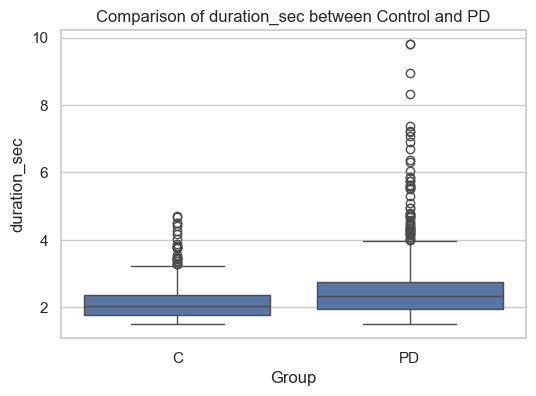

  Mann-Whitney U Test:
    U-statistic: 267499.50
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: pelvis_avg_speed


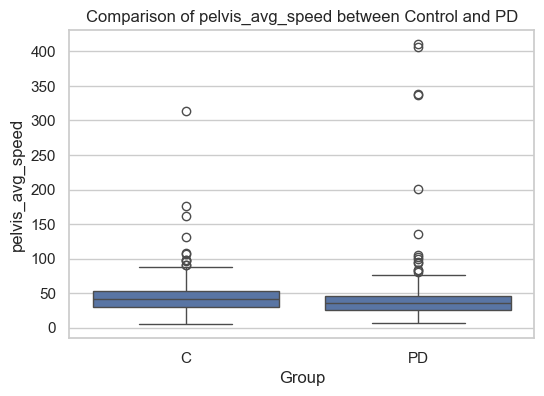

  Mann-Whitney U Test:
    U-statistic: 446541.50
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: pelvis_peak_speed


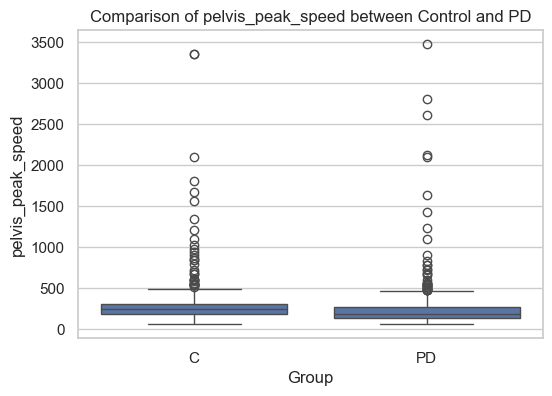

  Mann-Whitney U Test:
    U-statistic: 449445.00
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: pelvis_avg_jerk_mag


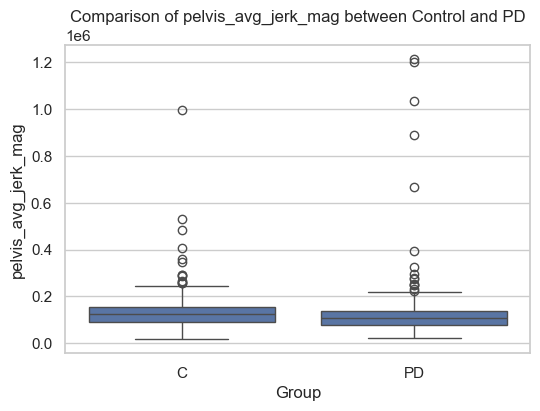

  Mann-Whitney U Test:
    U-statistic: 449418.00
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: trunk_total_rotation_deg


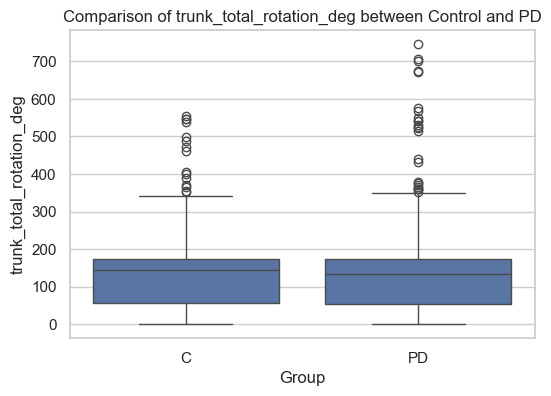

  Mann-Whitney U Test:
    U-statistic: 387923.50
    P-value: 0.3677
    Difference is not statistically significant (p >= 0.05)

Comparing feature: trunk_avg_ang_vel


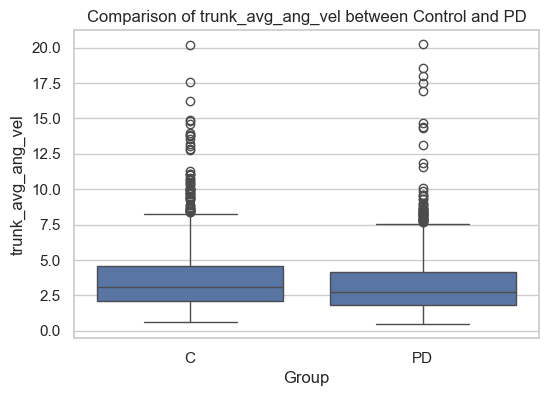

  Mann-Whitney U Test:
    U-statistic: 419435.00
    P-value: 0.0001
    Difference is statistically significant (p < 0.05)

Comparing feature: trunk_peak_ang_vel


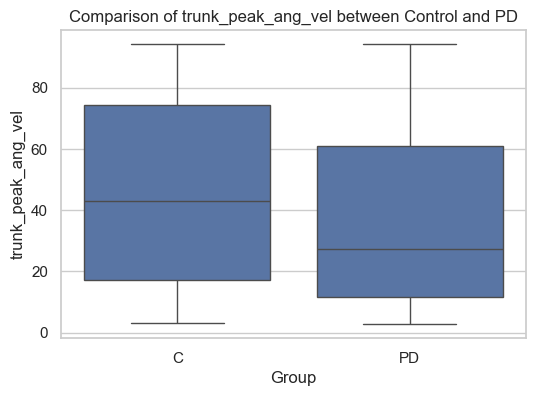

  Mann-Whitney U Test:
    U-statistic: 429435.50
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: number_of_turning_steps


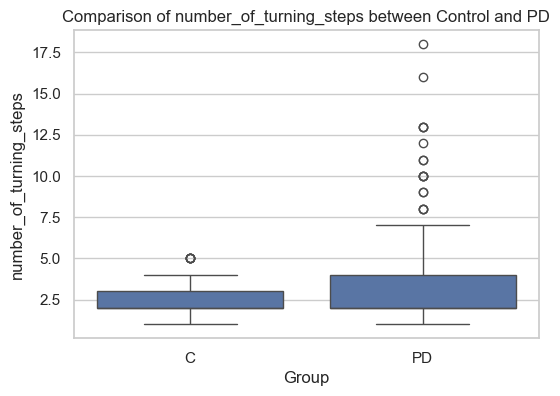

  Mann-Whitney U Test:
    U-statistic: 279198.00
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For statistical testing

# Set plot style
sns.set(style="whitegrid")

# Check if the final DataFrame exists
if 'df_labels_with_features' in locals() and df_labels_with_features is not None:

    print("--- Comparing Features between PD and Control Groups ---")

    # Select features to compare (choose ones relevant to PD symptoms)
    features_to_compare = [
        'duration_sec',             # Slowness
        'pelvis_avg_speed',         # Slowness
        'pelvis_peak_speed',        # Slowness / Ability to generate speed
        'pelvis_avg_jerk_mag',      # Smoothness (expect higher in PD)
        'trunk_total_rotation_deg', # Range of motion (expect smaller in PD?)
        'trunk_avg_ang_vel',        # Slowness of rotation
        'trunk_peak_ang_vel',       # Ability to generate rotational speed
        'number_of_turning_steps'   # Stepping strategy (from labels)
    ]

    # Separate data for easier testing
    pd_group =    [df_labels_with_features['PD_or_C'] == 'PD']
    control_group = df_labels_with_features[df_labels_with_features['PD_or_C'] == 'C']

    print(f"\nNumber of turns - PD: {len(pd_group)}, Control: {len(control_group)}")

    # --- Visualization and Statistical Testing ---
    for feature in features_to_compare:
        if feature not in df_labels_with_features.columns:
            print(f"\nWarning: Feature '{feature}' not found in DataFrame. Skipping.")
            continue

        print(f"\nComparing feature: {feature}")

        # 1. Visualization (Box Plot)
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='PD_or_C', y=feature, data=df_labels_with_features, order=['C', 'PD'])
        plt.title(f'Comparison of {feature} between Control and PD')
        plt.xlabel("Group")
        plt.ylabel(feature)
        plt.show()

        # 2. Statistical Test (Mann-Whitney U test)
        # Drop NaNs for this specific comparison before testing
        group1 = control_group[feature].dropna()
        group2 = pd_group[feature].dropna()

        if len(group1) > 0 and len(group2) > 0:
            try:
                stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                print(f"  Mann-Whitney U Test:")
                print(f"    U-statistic: {stat:.2f}")
                print(f"    P-value: {p_value:.4f}")
                if p_value < 0.05:
                    print("    Difference is statistically significant (p < 0.05)")
                else:
                    print("    Difference is not statistically significant (p >= 0.05)")
            except ValueError as e:
                # Handle potential issues like identical data causing errors in the test
                 print(f"  Could not perform Mann-Whitney U test for {feature}: {e}")
        else:
            print(f"  Not enough data in one or both groups to perform test for {feature}.")


else:
    print("DataFrame 'df_labels_with_features' not found.")
    print("Please ensure the previous cell successfully created and populated this DataFrame.")

--- Comparing Features between PD 'On' and 'Off' Medication States ---
Medication states found in PD data: ['On medication' 'Off medication' 'Control']

Number of turns - PD On: 748, PD Off: 214

Comparing feature: duration_sec (On vs Off Meds)


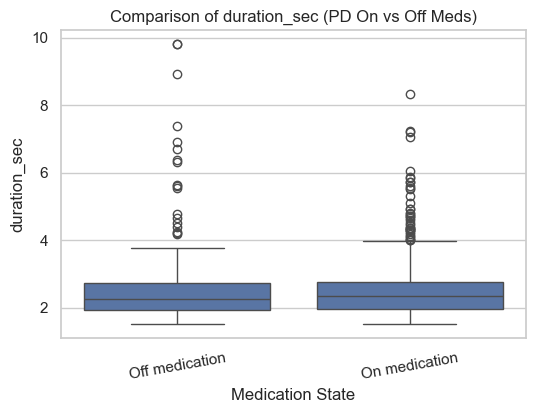

  Mann-Whitney U Test:
    U-statistic: 78474.50
    P-value: 0.6631
    Difference is not statistically significant (p >= 0.05)

Comparing feature: pelvis_avg_speed (On vs Off Meds)


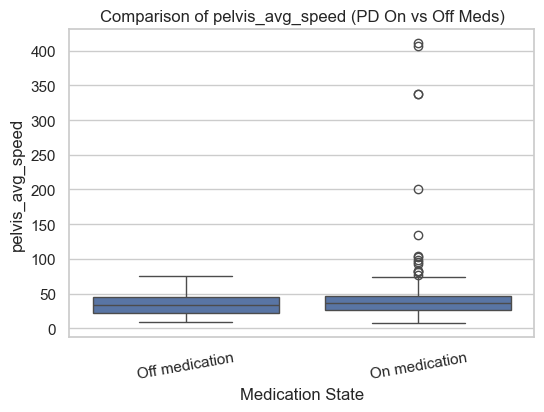

  Mann-Whitney U Test:
    U-statistic: 74454.00
    P-value: 0.1194
    Difference is not statistically significant (p >= 0.05)

Comparing feature: pelvis_peak_speed (On vs Off Meds)


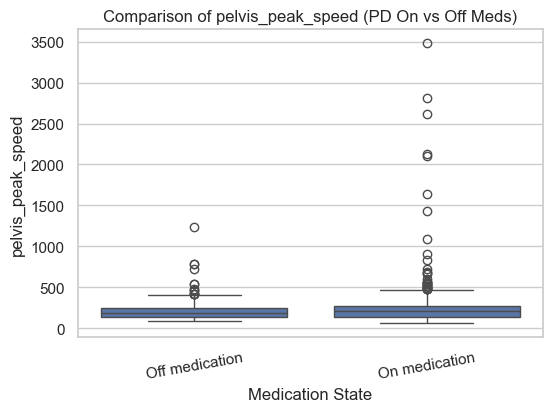

  Mann-Whitney U Test:
    U-statistic: 68511.00
    P-value: 0.0012
    Difference is statistically significant (p < 0.05)

Comparing feature: pelvis_avg_jerk_mag (On vs Off Meds)


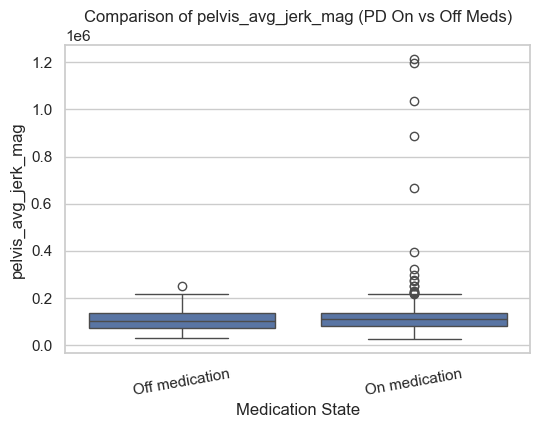

  Mann-Whitney U Test:
    U-statistic: 73863.00
    P-value: 0.0850
    Difference is not statistically significant (p >= 0.05)

Comparing feature: trunk_total_rotation_deg (On vs Off Meds)


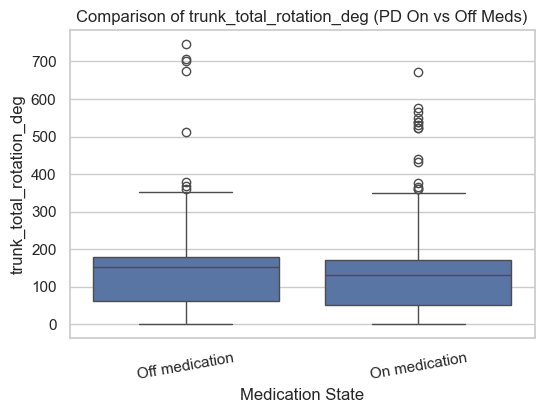

  Mann-Whitney U Test:
    U-statistic: 87661.00
    P-value: 0.0334
    Difference is statistically significant (p < 0.05)

Comparing feature: trunk_avg_ang_vel (On vs Off Meds)


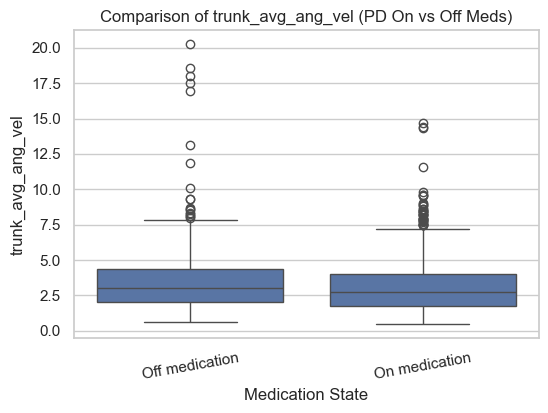

  Mann-Whitney U Test:
    U-statistic: 88323.00
    P-value: 0.0208
    Difference is statistically significant (p < 0.05)

Comparing feature: trunk_peak_ang_vel (On vs Off Meds)


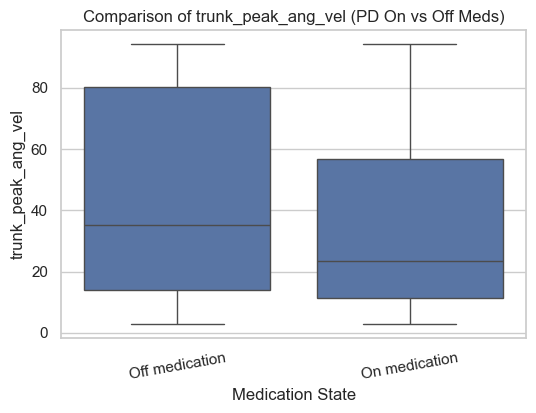

  Mann-Whitney U Test:
    U-statistic: 92102.50
    P-value: 0.0008
    Difference is statistically significant (p < 0.05)

Comparing feature: number_of_turning_steps (On vs Off Meds)


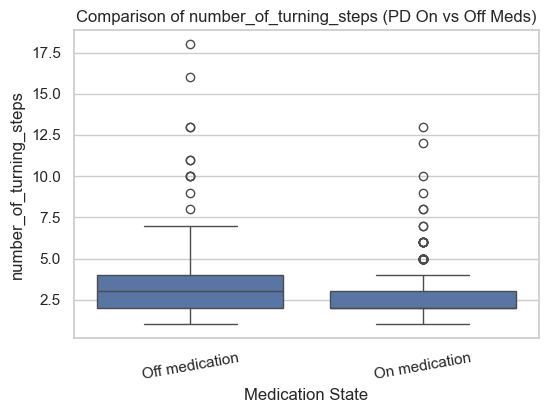

  Mann-Whitney U Test:
    U-statistic: 88985.50
    P-value: 0.0089
    Difference is statistically significant (p < 0.05)


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For statistical testing
import pandas as pd
import numpy as np # Ensure numpy is imported

# Set plot style
sns.set(style="whitegrid")

# Check if the final DataFrame exists
if 'df_labels_with_features' in locals() and df_labels_with_features is not None:

    print("--- Comparing Features between PD 'On' and 'Off' Medication States ---")

    # Filter for PD participants only
    df_pd_only = df_labels_with_features[df_labels_with_features['PD_or_C'] == 'PD'].copy()

    # Check if there are both On and Off medication states present
    med_states_present = df_pd_only['On_or_Off_medication'].unique()
    print(f"Medication states found in PD data: {med_states_present}")

    if 'On medication' in med_states_present and 'Off medication' in med_states_present:

        # Use the same features as before, or select a different subset
        features_to_compare = [
            'duration_sec',
            'pelvis_avg_speed',
            'pelvis_peak_speed',
            'pelvis_avg_jerk_mag',
            'trunk_total_rotation_deg',
            'trunk_avg_ang_vel',
            'trunk_peak_ang_vel',
            'number_of_turning_steps'
        ]

        # Separate data for easier testing
        pd_on = df_pd_only[df_pd_only['On_or_Off_medication'] == 'On medication']
        pd_off = df_pd_only[df_pd_only['On_or_Off_medication'] == 'Off medication']

        print(f"\nNumber of turns - PD On: {len(pd_on)}, PD Off: {len(pd_off)}")

        # --- Visualization and Statistical Testing ---
        for feature in features_to_compare:
            if feature not in df_pd_only.columns:
                print(f"\nWarning: Feature '{feature}' not found in DataFrame. Skipping.")
                continue

            print(f"\nComparing feature: {feature} (On vs Off Meds)")

            # 1. Visualization (Box Plot)
            plt.figure(figsize=(6, 4))
            # Explicitly order the boxes
            order = ['Off medication', 'On medication']
            sns.boxplot(x='On_or_Off_medication', y=feature, data=df_pd_only, order=order)
            plt.title(f'Comparison of {feature} (PD On vs Off Meds)')
            plt.xlabel("Medication State")
            plt.ylabel(feature)
            plt.xticks(rotation=10) # Rotate labels slightly if needed
            plt.show()

            # 2. Statistical Test (Mann-Whitney U test)
            # Drop NaNs for this specific comparison before testing
            group1 = pd_off[feature].dropna()
            group2 = pd_on[feature].dropna()

            if len(group1) > 0 and len(group2) > 0:
                try:
                    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                    print(f"  Mann-Whitney U Test:")
                    print(f"    U-statistic: {stat:.2f}")
                    print(f"    P-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print("    Difference is statistically significant (p < 0.05)")
                        # You might infer direction from box plots or group means
                        # print(f"    Mean Off: {group1.mean():.2f}, Mean On: {group2.mean():.2f}")
                    else:
                        print("    Difference is not statistically significant (p >= 0.05)")
                except ValueError as e:
                     print(f"  Could not perform Mann-Whitney U test for {feature}: {e}")
            else:
                print(f"  Not enough data in one or both groups (On/Off) to perform test for {feature}.")

    else:
        print("\nCould not find both 'On medication' and 'Off medication' states in the PD data.")
        print("Cannot perform On vs Off comparison.")

else:
    print("DataFrame 'df_labels_with_features' not found.")
    print("Please ensure the previous cells successfully created and populated this DataFrame.")

--- Comparing Features between Pivot and Step Turns ---
Turn types found: ['pivot_turn' 'step_turn' '-']

Number of turns - Pivot: 1475, Step: 233

Comparing feature: duration_sec (Pivot vs Step Turn)


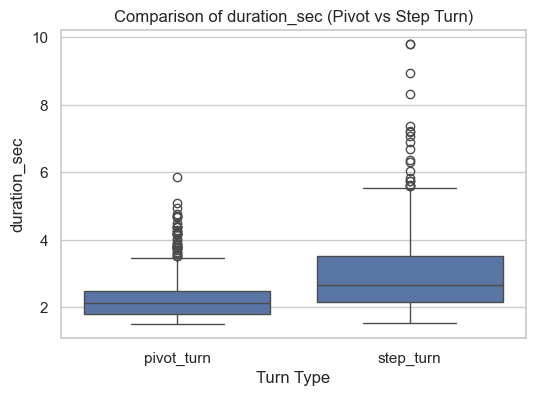

  Mann-Whitney U Test:
    U-statistic: 91208.50
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: number_of_turning_steps (Pivot vs Step Turn)


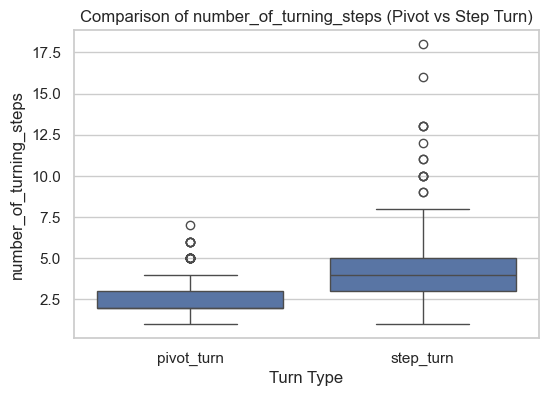

  Mann-Whitney U Test:
    U-statistic: 62600.50
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: pelvis_path_length (Pivot vs Step Turn)


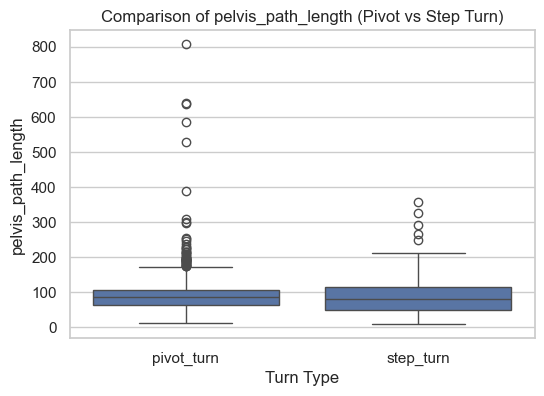

  Mann-Whitney U Test:
    U-statistic: 178017.00
    P-value: 0.3771
    Difference is not statistically significant (p >= 0.05)

Comparing feature: pelvis_avg_speed (Pivot vs Step Turn)


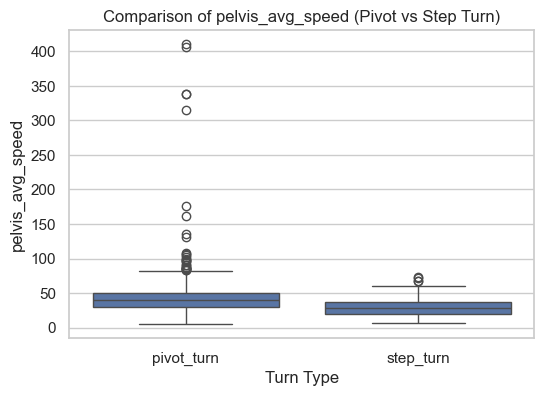

  Mann-Whitney U Test:
    U-statistic: 243089.00
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: trunk_total_rotation_deg (Pivot vs Step Turn)


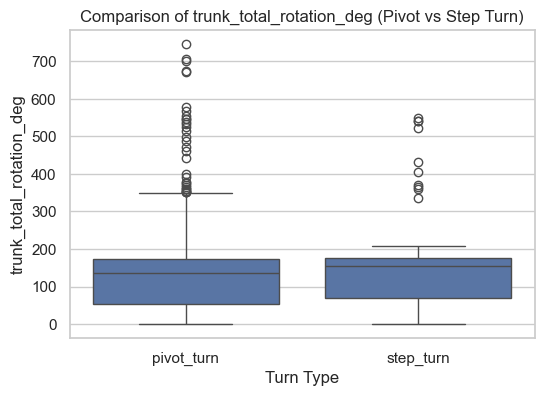

  Mann-Whitney U Test:
    U-statistic: 156399.50
    P-value: 0.0273
    Difference is statistically significant (p < 0.05)

Comparing feature: trunk_avg_ang_vel (Pivot vs Step Turn)


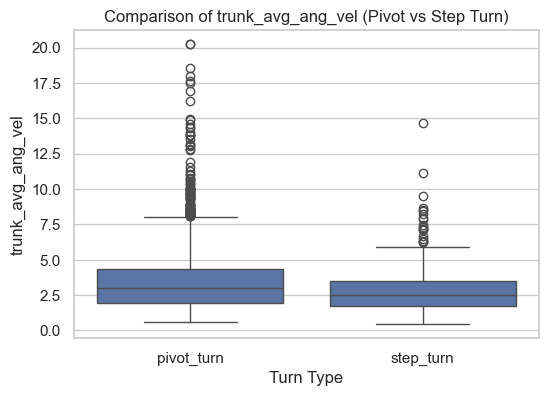

  Mann-Whitney U Test:
    U-statistic: 200749.00
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)

Comparing feature: pelvis_avg_jerk_mag (Pivot vs Step Turn)


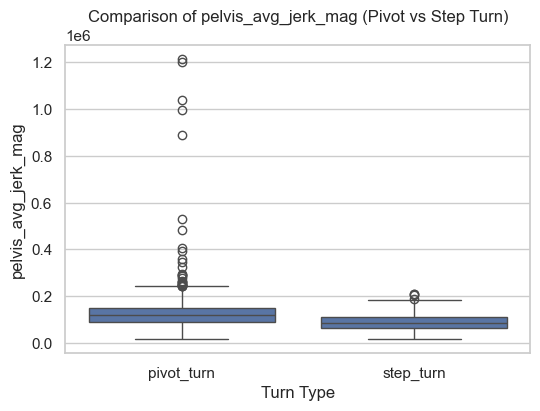

  Mann-Whitney U Test:
    U-statistic: 245043.00
    P-value: 0.0000
    Difference is statistically significant (p < 0.05)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For statistical testing
import pandas as pd
import numpy as np # Ensure numpy is imported

# Set plot style
sns.set(style="whitegrid")

# Check if the final DataFrame exists
if 'df_labels_with_features' in locals() and df_labels_with_features is not None:

    print("--- Comparing Features between Pivot and Step Turns ---")

    # Check if the 'type_of_turn' column exists and clean potential NaNs
    if 'type_of_turn' not in df_labels_with_features.columns:
        print("Error: 'type_of_turn' column not found in DataFrame.")
    else:
        # Filter out rows where turn type is missing (NaN)
        df_typed_turns = df_labels_with_features.dropna(subset=['type_of_turn']).copy()

        # Check if both turn types are present
        turn_types_present = df_typed_turns['type_of_turn'].unique()
        print(f"Turn types found: {turn_types_present}")

        if 'pivot_turn' in turn_types_present and 'step_turn' in turn_types_present:

            # Select features likely affected by turning strategy
            features_to_compare = [
                'duration_sec',
                'number_of_turning_steps', # Expect difference based on definition
                'pelvis_path_length',      # Step turns might cover more ground?
                'pelvis_avg_speed',
                'trunk_total_rotation_deg',# Does strategy affect rotation amount?
                'trunk_avg_ang_vel',       # Does strategy affect rotation speed?
                'pelvis_avg_jerk_mag'      # Is one strategy smoother?
            ]

            # Separate data for easier testing
            pivot_group = df_typed_turns[df_typed_turns['type_of_turn'] == 'pivot_turn']
            step_group = df_typed_turns[df_typed_turns['type_of_turn'] == 'step_turn']

            print(f"\nNumber of turns - Pivot: {len(pivot_group)}, Step: {len(step_group)}")

            # --- Visualization and Statistical Testing ---
            for feature in features_to_compare:
                if feature not in df_typed_turns.columns:
                    print(f"\nWarning: Feature '{feature}' not found in DataFrame. Skipping.")
                    continue

                print(f"\nComparing feature: {feature} (Pivot vs Step Turn)")

                # 1. Visualization (Box Plot)
                plt.figure(figsize=(6, 4))
                order = ['pivot_turn', 'step_turn'] # Define order
                sns.boxplot(x='type_of_turn', y=feature, data=df_typed_turns, order=order)
                plt.title(f'Comparison of {feature} (Pivot vs Step Turn)')
                plt.xlabel("Turn Type")
                plt.ylabel(feature)
                plt.show()

                # 2. Statistical Test (Mann-Whitney U test)
                # Drop NaNs for this specific comparison before testing
                group1 = pivot_group[feature].dropna()
                group2 = step_group[feature].dropna()

                if len(group1) > 0 and len(group2) > 0:
                    try:
                        stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                        print(f"  Mann-Whitney U Test:")
                        print(f"    U-statistic: {stat:.2f}")
                        print(f"    P-value: {p_value:.4f}")
                        if p_value < 0.05:
                            print("    Difference is statistically significant (p < 0.05)")
                        else:
                            print("    Difference is not statistically significant (p >= 0.05)")
                    except ValueError as e:
                        print(f"  Could not perform Mann-Whitney U test for {feature}: {e}")
                else:
                    print(f"  Not enough data in one or both groups (Pivot/Step) to perform test for {feature}.")

        else:
            print("\nCould not find both 'pivot_turn' and 'step_turn' values in the 'type_of_turn' column.")
            print("Cannot perform Pivot vs Step comparison.")

else:
    print("DataFrame 'df_labels_with_features' not found.")
    print("Please ensure the previous cells successfully created and populated this DataFrame.")

In [15]:
import numpy as np
import pandas as pd

def calculate_turn_features_3d(df_kp, frame_rate=30.0):
    """
    Calculates various 3D-specific features from a 3D keypoint DataFrame,
    focusing on Pelvis kinematics, trunk rotation, and vertical movement.

    Args:
        df_kp (pd.DataFrame): DataFrame with 3D keypoint data.
        frame_rate (float): Frame rate of the capture (e.g., 30.0 fps).

    Returns:
        dict: A dictionary containing the calculated features, or None if input is invalid.
    """
    if df_kp is None or df_kp.empty or len(df_kp) < 4:
        # Not enough data for robust feature calculation
        return None

    features = {}
    dt = 1.0 / frame_rate if frame_rate > 0 else 0

    # --- Basic Features ---
    features['duration_frames'] = len(df_kp)
    features['duration_sec'] = features['duration_frames'] * dt

    # --- 3D Features based on Pelvis (Joint 0) ---
    pelvis_cols = ['x0', 'y0', 'z0']
    pelvis_coords = df_kp[pelvis_cols].copy()
    diffs = pelvis_coords.diff().fillna(0)

    # 3D Path Length & Displacement
    step_distances_3d = np.sqrt((diffs**2).sum(axis=1))
    features['pelvis_path_length_3d'] = step_distances_3d.sum()

    start_pos = pelvis_coords.iloc[0]
    end_pos = pelvis_coords.iloc[-1]
    features['pelvis_displacement_3d'] = np.sqrt(((end_pos - start_pos)**2).sum())

    # --- 3D Kinematics (Velocity, Acceleration, Jerk for Pelvis) ---
    if dt > 0:
        velocity = diffs / dt
        speed_3d = np.sqrt((velocity**2).sum(axis=1))
        features['pelvis_avg_speed_3d'] = speed_3d.mean()
        features['pelvis_peak_speed_3d'] = speed_3d.max()

        accel = velocity.diff().fillna(0) / dt
        accel_mag_3d = np.sqrt((accel**2).sum(axis=1))
        features['pelvis_avg_accel_mag_3d'] = accel_mag_3d.mean()
        features['pelvis_peak_accel_mag_3d'] = accel_mag_3d.max()

        jerk = accel.diff().fillna(0) / dt
        jerk_mag_3d = np.sqrt((jerk**2).sum(axis=1))
        features['pelvis_avg_jerk_mag_3d'] = jerk_mag_3d.mean()

    # --- 3D-Specific Features (Vertical Movement) ---
    features['pelvis_vertical_displacement'] = abs(df_kp['z0'].iloc[-1] - df_kp['z0'].iloc[0])
    if dt > 0:
        features['pelvis_avg_vertical_speed'] = abs(df_kp['z0'].diff().fillna(0) / dt).mean()

    # Average height of all keypoints as a proxy for posture
    z_cols_all = [col for col in df_kp.columns if col.startswith('z')]
    if z_cols_all:
        features['mean_body_height'] = df_kp[z_cols_all].mean().mean()

    # --- Features based on Trunk Rotation (2D Projection is often sufficient and more stable) ---
    # Using the X-Y plane projection for rotation angle calculation
    dx = df_kp['x14'] - df_kp['x11']
    dy = df_kp['y14'] - df_kp['y11']
    unwrapped_angles_rad = np.unwrap(np.arctan2(dy, dx))
    features['trunk_total_rotation_deg'] = np.degrees(abs(unwrapped_angles_rad[-1] - unwrapped_angles_rad[0]))

    if dt > 0:
         angular_velocity = pd.Series(unwrapped_angles_rad).diff().fillna(0) / dt
         features['trunk_avg_ang_vel'] = abs(angular_velocity).mean()
         features['trunk_peak_ang_vel'] = abs(angular_velocity).max()

    return features

print("Function 'calculate_turn_features_3d' created and ready for use.")

Function 'calculate_turn_features_3d' created and ready for use.


In [16]:
# --- Iterate through labels, load 3D data, calculate features, and save to CSV ---

if 'df_labels' in locals() and df_labels is not None:
    print("Processing turns using 3D data...")

    dimension_to_process = '3D' # Set to 3D
    frame_rate_to_use = 30.0

    results_3d = []
    total_turns = len(df_labels)

    print(f"Starting feature extraction for {total_turns} turns...")
    for index, turn_info_row in df_labels.iterrows():
        turn_id = int(turn_info_row['Turn ID'])
        # Print progress
        if (index + 1) % 100 == 0 or index == 0:
             print(f"Processing turn {index + 1}/{total_turns} (ID: {turn_id})...")

        # Load the 3D keypoint data for the current turn
        df_kp_3d = load_turn_data(turn_info_row, dimension=dimension_to_process, base_path=base_data_path)

        # Calculate features if data was loaded successfully
        feature_dict = None
        if df_kp_3d is not None:
            # Use the new 3D feature calculation function
            feature_dict = calculate_turn_features_3d(df_kp_3d, frame_rate=frame_rate_to_use)

        # Store results
        if feature_dict is None:
             feature_dict = {}
        feature_dict['Turn ID'] = turn_id
        results_3d.append(feature_dict)


    # Convert results list to a DataFrame
    df_features_3d = pd.DataFrame(results_3d)

    # Merge features back into the original labels DataFrame
    df_labels_with_3d_features = pd.merge(df_labels, df_features_3d, on='Turn ID', how='left')

    # --- Save the final DataFrame to a CSV file ---
    output_filename = 'turning_project_3d_features.csv'
    df_labels_with_3d_features.to_csv(output_filename, index=False)

    print(f"\nFeature calculation complete.")
    print(f"Dataset with 3D features saved to '{output_filename}'")

    print("\nHead of the new DataFrame with 3D features:")
    display(df_labels_with_3d_features.head())

else:
    print("Labels DataFrame ('df_labels') not loaded. Please run the initial cells successfully.")

Processing turns using 3D data...
Starting feature extraction for 1749 turns...
Processing turn 1/1749 (ID: 0)...
Processing turn 100/1749 (ID: 174)...
Processing turn 200/1749 (ID: 350)...
Processing turn 300/1749 (ID: 606)...
Processing turn 400/1749 (ID: 922)...
Processing turn 500/1749 (ID: 1167)...
Processing turn 600/1749 (ID: 1367)...
Processing turn 700/1749 (ID: 1578)...
Processing turn 800/1749 (ID: 1783)...
Processing turn 900/1749 (ID: 2068)...
Processing turn 1000/1749 (ID: 2250)...
Processing turn 1100/1749 (ID: 2423)...
Processing turn 1200/1749 (ID: 2618)...
Processing turn 1300/1749 (ID: 2776)...
Processing turn 1400/1749 (ID: 3031)...
Processing turn 1500/1749 (ID: 3296)...
Processing turn 1600/1749 (ID: 3443)...
Processing turn 1700/1749 (ID: 3665)...

Feature calculation complete.
Dataset with 3D features saved to 'turning_project_3d_features.csv'

Head of the new DataFrame with 3D features:


,Turn ID,Participant ID number,PD_or_C,number_of_turning_steps,turning_angle,type_of_turn,turning_duration,On_or_Off_medication,DBS_state,clinical_assessment,...,pelvis_peak_speed_3d,pelvis_avg_accel_mag_3d,pelvis_peak_accel_mag_3d,pelvis_avg_jerk_mag_3d,pelvis_vertical_displacement,pelvis_avg_vertical_speed,mean_body_height,trunk_total_rotation_deg,trunk_avg_ang_vel,trunk_peak_ang_vel
0,0,230,C,4,90_degrees,pivot_turn,1.980999,Control,Control,No,...,0.480001,2.825012,12.599999,156.000450,0.460,0.196667,0.647025,124.552185,0.905769,1.653810
1,2,230,C,2,90_degrees,pivot_turn,1.278000,Control,Control,No,...,0.360001,2.505877,9.000045,133.411436,0.194,0.123529,0.685878,105.375035,1.081848,2.196131
2,4,230,C,2,90_degrees,pivot_turn,1.092999,Control,Control,No,...,0.900000,3.240001,12.600052,170.399773,0.520,0.346667,0.622105,100.903971,1.174071,2.836908
3,5,230,C,2,90_degrees,pivot_turn,1.205999,Control,Control,No,...,0.660000,3.342856,10.800022,180.734403,0.326,0.204490,0.657501,122.813421,1.312346,2.122240
4,7,230,C,2,90_degrees,pivot_turn,1.399000,Control,Control,No,...,0.480001,3.698182,16.200006,204.218171,0.406,0.225818,0.714165,127.633829,1.215071,2.957204
